# 프로젝트: 한국어 데이터로 챗봇 만들기
## 개요
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅니다.   

## 목차
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기
- Step 3. SubwordTextEncoder 사용하기
- Step 4. 모델 구성하기
- Step 5. 모델 평가하기

## 회고

## Reference
---

In [1]:
# 주요 라이브러리 버전 확인

import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.  
이 데이터는 아래의 링크에서 다운로드할 수 있습니다.  
- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)  

cloud shell에서 디렉토리를 생성하고 데이터 디렉토리와 연결합니다.

In [2]:
# $ mkdir -p ~/aiffel/transformer_chatbot/data/
# $ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [2]:
# 패키지 임포트
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")

슝=3


In [3]:
# 데이터 불러오기 

data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')

In [4]:
# 데이터 샘플 확인하기 
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
# 전체 데이터 수
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11823


In [6]:
# 사용할 샘플의 최대 개수

MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


# Step 2. 데이터 전처리하기


한국어 데이터를 영어 데이터와 비교해보았을 때,  
- 공통점 : 구두점을 제거하여 단어를 토크나이징, 질문과 답변의 쌍을 전처리, 병렬 데이터 전처리
- 차이점 : 대소문자 변환이 필요 없음, 띄어쓰기가 문맥과 의미를 구분하는 데에 큰 영향을 준다.

---
띄어쓰기와 맞춤법 검사 전처리를 하고싶었으나 오류가 해결되지 않아 skip하였습니다.

In [8]:
# 띄어쓰기 라이브러리 설치
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-tc6aog2y
  Running command git clone --filter=blob:none -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-tc6aog2y
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 04aeebcbe26b109486a642e57dc58665c4818cf3
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.11.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached h5py-3.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
     |████████████████████████████████| 18.2 MB 8.4 MB/s            
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully 

In [32]:
# 띄어쓰기 라이브러리 설치
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git --no-deps argument

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-cbz4c07x
  Running command git clone --filter=blob:none -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-cbz4c07x
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 04aeebcbe26b109486a642e57dc58665c4818cf3
  Preparing metadata (setup.py) ... done


In [33]:
# 띄어쓰기가 잘 되는지 확인

from pykospacing import Spacing

sentence = 'V리그 여자부 흥국생명이 김연경과 옐레나의 쌍포를 앞세워 가장 먼저 10승 고지를 밟았다. 흥국생명은 25일 홈경기에서 도로공사를 상대로 세트 스코어 3대0(27-25 25-20 25-19) 완승을 거뒀다.'
sentence = sentence.replace(" ", '') # 띄어쓰기가 없는 문장 임의로 만들기
print(sentence)

AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'

In [16]:
tf.__version__ = "2.6.0"

In [ ]:
# TensorFlow 2.6.0에서 호환성을 유지하기 위해 tensorflow.compat.v1을 사용
import tensorflow.compat.v1 as tf_compat
tf_compat.disable_v2_behavior()

# PyKoSpacing을 불러올 때 에러가 발생하지 않도록 모델 로딩 시 예외 처리 추가
try:
    from pykospacing import Spacing
except Exception as e:
    print("Error loading PyKoSpacing:", str(e))

In [ ]:
sentence = 'V리그 여자부 흥국생명이 김연경과 옐레나의 쌍포를 앞세워 가장 먼저 10승 고지를 밟았다. 흥국생명은 25일 홈경기에서 도로공사를 상대로 세트 스코어 3대0(27-25 25-20 25-19) 완승을 거뒀다.'
sentence = sentence.replace(" ", '') # 띄어쓰기가 없는 문장 임의로 만들기

# PyKoSpacing 모델이 로드되었는지 확인 후 사용
if 'Spacing' in locals():
    spacing = Spacing()
    spaced_sentence = spacing(sentence)
    print(spaced_sentence)
else:
    print("PyKoSpacing 모델이 로드되지 않았습니다.")

텐서플로우 버전 호환의 문제로 보이나 현재 버전을 유지하고 싶어서 다른 띄어쓰기&맞춤법 검사 패키지인 Py-Hanspell을 써보겠습니다.

In [ ]:
!pip install py-hanspell

In [ ]:
# Py-Hanspell 패키지 불러오기

from hanspell import spell_checker

sentence = 'V리그 여자부 흥국생명이 김연경과 옐레나의 쌍포를 앞세워 가장 먼저 10승 고지를 밟았다. 흥국생명은 25일 홈경기에서 도로공사를 상대로 세트 스코어 3대0(27-25 25-20 25-19) 완승을 거뒀다.'
spelled_sent = spell_checker.check(sentence)

sentence = spelled_sent.checked
print(sentence)

---
띄어쓰기 전처리가 쉽지 않습니다. 일단은 구두점 전처리를 진행해봅니다.

In [7]:
# 전처리 함수

def preprocess_sentence(sentence):

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
    
  return sentence
print("슝=3")

슝=3


## 질문과 답변의 쌍을 전처리
csv 파일에 이미 질문과 답변으로 구분되어 있으므로 변수에 담아 확인 작업만 해보겠습니다.

In [8]:
# 질문과 답변의 쌍 확인
questions = [preprocess_sentence(sentence) for sentence in data['Q']]
answers = [preprocess_sentence(sentence) for sentence in data['A']]

In [9]:
# 데이터의 샘플 수 확인
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


질문과 답변의 샘플 수가 일치하는 것을 확인했습니다.

In [10]:
# 질문과 답변의 쌍 테스트 
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# Step 3. SubwordTextEncoder 사용하기

## 병렬 데이터 전처리 하기
질문과 답변의 셋을 각각 questions과 answers에 저장하였으므로, 본격적으로 전처리를 진행해보겠습니다.  
이번 스텝에서 진행할 전체적인 과정을 요약하면 다음과 같습니다.  

1. TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  
단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.  

## 1. 단어장(Vocabulary) 만들기
우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다.  
단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.

In [11]:
# TensorFlow Datasets SubwordTextEncoder를 토크나이저로 import

import tensorflow_datasets as tfds
print("완료")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

완료
슝=3 


## 시작 토큰, 종료 토큰에 고유한 정수 부여
이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다.  
이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 됩니다.

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [13]:
# 시작 토큰과 종료 토큰에 부여된 정수 출력해보기 

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8129]
END_TOKEN의 번호 : [8130]


각각 8,129과 8,130라는 점에서 현재 단어장의 크기가 8,129(0번부터 8,128번)이라는 의미입니다.  
2개의 토큰을 추가해주었기 때문에 단어장의 크기도 +2임을 명시해주어야 합니다.

In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다. 

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8131


## 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었으므로,
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5744, 612, 2483, 4149]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7483, 7, 6248, 97, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다.  
위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩 을 수행합니다.  
문장의 최대 길이를 정하고, 해당 길이로 패딩(padding)합니다.

In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이

MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


> **패딩 코드 주석**   
> tf.keras.preprocessing.sequence.pad_sequences 함수는 시퀀스를 패딩하여 최대 길이(maxlen)에 도달하지 못하는 경우에는 'post' 옵션을 사용하여 패딩을 시행합니다.
>
> - tokenized_inputs: 패딩을 적용할 정수 인코딩된 입력 시퀀스의 리스트
> - maxlen=MAX_LENGTH: 패딩 후 시퀀스의 최대 길이. MAX_LENGTH로 정의된 값입니다.
> - padding='post': 패딩을 시행할 위치. 'post'는 시퀀스의 뒷부분에 패딩을 추가한다는 의미입니다.  
    
정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다.
단어장의 크기와 샘플의 개수를 확인해 보겠습니다.

In [18]:
# 단어장의 크기와 샘플의 개수 확인 (최대 길이 40을 넘는 경우를 샘플링한 이후)

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8131
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


> 위의 코드를 실행했을 때 오류가 발생하였다. 텐서플로우의 버전을 바꿔보았으나 해결이 되지 않았고, 커널을 죽였다가 다시 켜보니 정상적으로 돌아갔다.  
이렇게 꼬였을 때는 커널을 죽였다가 다시 실행해보는 것도 방법임을 배웠다!  
>
>[오류 코드]
AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'

## 3. 교사 강요(Teacher Forcing) 사용하기
tf.data.Dataset API 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.  
이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 합니다.    

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다.  
이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값(각 샘플에서 마지막 원소를 제외한 부분),  
answers[:, 1:]를 디코더의 레이블(answer의 각 샘플에서 첫번째 원소를 제외한 부분)로 사용합니다.

In [19]:
# 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()   # 데이터셋을 캐시에 저장하여 훈련 속도를 높입니다.
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)   # 데이터를 GPU로 효율적으로 전달하기 위해 필요한 만큼의 데이터를 미리 준비합니다.
print("슝=3")

슝=3


# Step 4. 모델 구성하기


## 포지셔널 인코딩
트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받습니다.  
따라서 위치와 맥락 정보를 제대로 적용하기 어려우므로 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해줍니다.  

### 포지셔널 행렬 구현하기

In [20]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    # PositionalEncoding 메서드 : 포지셔널 인코딩을 위한 각도 배열을 생성
    super(PositionalEncoding, self).__init__()
    # positional_encoding 메서드를 호출하여 pos_encoding 변수에 저장
    self.pos_encoding = self.positional_encoding(position, d_model)

    # get_anfles 메서드 : 각도 배열을 생성하기 위해 사용. 주어진 위치(position), 인덱스(i), 및 임베딩 차원(d_model)에 대한 각도를 계산.
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

    # positional_encoding : 각도 배열을 생성하고, 짝수 인덱스에는 사인 함수를, 홀수 인덱스에는 코사인 함수를 적용한 후, sin과 cosine이 교차되도록 재배열 
  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

    # 입력에 포지셔널 인코딩 값을 더하여 반환. 포지셔널 인코딩의 길이를 입력의 길이에 맞게 자릅니다.
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


## 어텐션
어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다.  
구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해 줍니다.  
유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 합니다.

### 스케일드 닷 프로덕트 어텐션 구현하기
내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구한 스케일드 닷 프로덕트 어텐션 함수를 구현해보겠습니다.

In [22]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # matmul_qk: Query(Q)와 Key(K) 간의 닷 프로덕트를 계산. 이는 어텐션 가중치를 구하기 위한 중간 단계. 어텐션 가중치는 Q와 K의 닷 프로덕트.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
    # logits : 닷 프로덕트를 행렬의 깊이(depth)로 나누어 스케일링을 수행
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가 : mask가 주어졌다면, 어텐션 가중치에 패딩에 대한 마스크를 적용
    # 패딩은 어텐션 계산 시 무시되어야 하므로, 해당 위치의 어텐션 가중치를 크게 음의 무한대로 만듭니다.
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용 : Softmax 함수를 사용하여 어텐션 가중치를 계산. 이는 어텐션 가중치를 확률 분포로 만듭니다.
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V(Value)의 닷 프로덕트 -> 이를 통해 쿼리에 대한 어텐션 값을 계산
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


> 참조 : np.matmul()은 매트릭스, 행렬 곱을 수행하는 메소드  


### 멀티헤드 어텐션 구현하기
내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출합니다.

In [23]:
# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리(헤드)를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


**스케일드 닷 프로덕트 어텐션 함수 주석**


이 부분은 Multi-Head Attention에서 각 헤드에서 계산된 어텐션 가중치를 조작하는 부분입니다.  
Multi-Head Attention은 여러 헤드에서 각기 다른 어텐션 가중치를 계산하고, 이를 나중에 결합(concatenate)하여 최종 결과를 얻습니다.  

여기서 scaled_attention은 scaled_dot_product_attention 함수를 통해 얻어진 어텐션 가중치 행렬입니다.  

1. tf.transpose(scaled_attention, perm=[0, 2, 1, 3]):
- 어텐션 가중치 행렬의 차원을 조정합니다.
- scaled_attention의 형태는 (batch_size, num_heads, sequence_length, depth)이며, 여기서 sequence_length는 입력 시퀀스의 길이, depth는 각 헤드의 차원입니다.
- perm=[0, 2, 1, 3]는 차원의 순서를 조정하는데, 두 번째와 세 번째 차원을 서로 바꾸어주어 헤드별로 어텐션 가중치를 정렬합니다.
- 결과적으로 어텐션 가중치 행렬의 형태는 (batch_size, sequence_length, num_heads, depth)이 됩니다.

2. tf.reshape(scaled_attention, (batch_size, -1, self.d_model)):
- tf.reshape를 사용하여 행렬의 형태를 조정합니다.
- -1은 해당 차원의 크기를 자동으로 계산하라는 의미입니다. 여기서는 num_heads * depth에 해당하는 값이 됩니다.
- 결과적으로 최종 어텐션 가중치의 형태는 (batch_size, sequence_length, d_model)이 됩니다.

## 마스킹
### 패딩 마스킹(Padding Masking)

In [24]:
# 패딩 마스킹 함수 구현

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

# tf.math.equal(x, 0) : 입력 x에서 값이 0인 위치를 찾아 True로 표시한 불리언 텐서를 생성합니다. 이는 패딩 토큰에 해당하는 위치를 나타냅니다.
# tf.cast(..., tf.float32) : 
# 불리언 텐서를 0 또는 1의 값을 가지는 실수형 텐서로 변환. 따라서 패딩 토큰의 위치는 1의 값을 가지고, 나머지 위치는 0의 값을 가지게 됩니다.
# mask[:, tf.newaxis, tf.newaxis, :]:
# 마스크 텐서의 차원을 확장합니다. tf.newaxis를 사용하여 새로운 축을 추가하고, 이를 통해 적절한 차원을 맞춥니다.
# 최종적으로 반환되는 패딩 마스크의 형태는 (batch_size, 1, 1, sequence_length)가 됩니다.

슝=3


이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴합니다.  
(이 함수를 호출하면 입력 시퀀스에서 패딩 토큰에 해당하는 위치를 가리키는 패딩 마스크가 생성되어 반환됩니다.   
이 마스크는 어텐션 연산에서 패딩 토큰의 영향을 배제하는 데 사용됩니다.)  

두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 보겠습니다.

In [25]:
# 테스트 - 2개의 정수 시퀀스 입력해보기

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.  
어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있습니다.

### Look-ahead masking : 다음 단어 가리기
트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있습니다.  
그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요합니다.

In [27]:
# look-ahead masking 함수 구현 (빨강색 부분 = 다음 단어 가리기)

def create_look_ahead_mask(x):
    # 입력 x의 시퀀스 길이를 구합니다. 즉, 시퀀스의 두 번째 차원의 크기를 가져와서 seq_len 변수에 저장합니다.
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")


# look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0):
# tf.ones((seq_len, seq_len))를 사용하여 모든 원소가 1인 행렬을 만듭니다.
# tf.linalg.band_part(..., -1, 0)를 사용하여 행렬의 아래 삼각행렬을 0으로 만들고, 위 삼각행렬은 1로 남깁니다.
# 1 - ...를 통해 원래의 위 삼각행렬이 0이 되고, 아래 삼각행렬이 1이 되도록 합니다. 이것이 룩 어헤드 마스크입니다.

# padding_mask = create_padding_mask(x): 앞서 정의한 create_padding_mask 함수를 사용하여 패딩 마스크를 생성합니다.

# tf.maximum(look_ahead_mask, padding_mask):
# 룩 어헤드 마스크와 패딩 마스크 중에서 더 큰 값을 선택합니다. 
# 이는 룩 어헤드 마스크와 패딩 마스크 중에서 더 큰 영향을 주는 위치를 선택하는 것으로, 어텐션 연산에서 사용될 마스크를 결정합니다.

슝=3


In [28]:
# 직접 입력을 넣어 테스트 해보기

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더
### 인코더 층 만들기
하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.

- 인코더 층 = 셀프 어텐션 + 피드 포워드 신경망
- 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

In [29]:
# 인코더 층 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")   
    # shape=(배치 사이즈, 헤드의 수, 시퀀스 길이)
    # 시퀀스의 길이 = None : 입력 시퀀스의 길이에 따라 동적으로 조정될 수 있다는 의미

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행 (어텐션의 결과는 드롭아웃과 레이어 정규화를 거친다.)
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 인코더 층을 쌓아 인코더 만들기
인코더 층을 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고,  
사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.  

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다.  
위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.  

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다.  
논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [30]:
# 인코더 구현

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")   # inputs: 모델의 입력으로서 단어 인덱스들을 나타냅니다.

  # 패딩 마스크 사용 (encoder_layer 함수에서 사용됨)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)   # 단어 인덱스들을 임베딩하여 단어 벡터를 생성
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))   # 임베딩 차원에 루트를 씌워줌으로써 스케일 조정을 수행합니다.

  # 포지셔널 인코딩 : 임베딩 된 단어 벡터에 포지셔널 인코딩 처리 (입력 시퀀스의 각 단어 위치에 대한 상대적인 정보를 주입하는 역할)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)  # 드롭아웃을 적용하여 모델의 일반화 능력을 향상시킴

  # 여러 개의 인코더 레이어 쌓기 : num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


**def encoder 인자 뜯어보기**  

- vocab_size : 모델이 다루는 어휘 집합(Vocabulary size)의 크기를 나타냅니다.

    - 어휘 집합은 모델이 이해하고 다루는 단어나 토큰들의 총 개수를 말합니다.
    - 트랜스포머 모델은 입력으로 어휘 집합의 각 단어를 나타내는 정수 인덱스를 받습니다. vocab_size는 이러한 정수 인덱스의 범위를 나타냅니다.
    - 예를 들어, 만약 어휘 집합에 10,000개의 고유한 단어가 있다면 vocab_size는 10,000이 됩니다.
    - 일반적으로 어휘 집합의 크기는 자주 등장하는 단어를 포함할 수 있도록 설정됩니다.
    - 이 값은 모델의 입력 임베딩 레이어의 크기 및 학습 가능한 파라미터의 수에 영향을 미치게 됩니다.
    
- num_layers : 트랜스포머 모델의 인코더나 디코더에서 사용되는 레이어의 개수

    - 일반적으로 모델의 용량(capacity)을 늘리려면 레이어의 수를 늘리고, 그에 따라 학습할 수 있는 특징의 수가 증가합니다.
    - num_layers=6으로 설정하면 인코더나 디코더에서 각각 6개의 레이어를 쌓게 됩니다.
    - 이 값은 주로 모델의 복잡성과 데이터의 특성에 따라 조절되며, 실험과 검증을 통해 최적의 값을 찾게 됩니다.
   
- units : 트랜스포머의 인코더 레이어나 디코더 레이어에서 사용되는 완전연결층(fully connected layer)의 출력 차원

    - 해당 레이어의 유닛 수를 결정하는 매개변수로, 모델의 용량(capacity)에 영향을 미칩니다.
    - 보통 units의 값은 트랜스포머의 차원인 d_model과 관련이 있습니다.
    - 예를 들어, units=d_model*4와 같이 설정될 수 있습니다.
    - 하지만 이는 일반적인 규칙은 아니며, 모델의 구조나 작업에 따라 최적의 값이 달라질 수 있습니다.

- d_model : 트랜스포머 모델에서 사용되는 임베딩 벡터의 차원(또는 특징의 차원)

    - 모델 내부에서 다양한 연산이 이루어지는 벡터의 차원으로, 트랜스포머의 핵심 파라미터 중 하나입니다.
    - 트랜스포머의 인코더와 디코더에서는 입력된 단어의 임베딩이 d_model 차원을 갖도록 설계됩니다.
    - 이 차원은 어텐션 메커니즘, 피드포워드 네트워크 등 다양한 연산에 적용되며, 모델의 용량(capacity)을 결정하는 중요한 요소 중 하나입니다.
    - 일반적으로 d_model은 트랜스포머의 하이퍼파라미터 중 하나로 설정되며, 주로 256, 512, 1024 등의 값이 사용됩니다.
    - 적절한 d_model의 선택은 모델의 학습과 일반화 성능에 영향을 미칩니다.

- num_heads :

    - 트랜스포머의 어텐션 메커니즘은 여러 헤드로 나누어져 병렬로 계산되고, 각 헤드의 출력이 합쳐져 최종 출력이 생성됩니다.
      이렇게 함으로써 모델은 각 헤드가 서로 다른 측면에 집중하도록 학습하게 되어 다양한 특징을 추출할 수 있습니다.
    - 일반적으로 num_heads는 8 또는 12와 같은 값으로 설정됩니다.
    - 적절한 num_heads의 선택은 모델의 성능과 효율성(계산 비용 대비 더 많은 병렬 계산 수행)에 영향을 미치므로 조심스럽게 결정되어야 합니다.

## 디코더
### 디코더 층
디코더는 인코더와 달리 3개의 서브 층으로 구성됩니다.   
첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다.

In [31]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    # inputs: 현재 디코더 레이어의 입력으로 들어가는 시퀀스.
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # enc_outputs: 인코더의 출력. 디코더는 이를 참조하여 인코더-디코더 어텐션을 수행.
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    # look_ahead_mask: 디코더 셀프 어텐션에서 사용되는 마스크. 현재 위치 이후의 토큰에 대한 정보를 가립니다.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    # padding_mask: 패딩을 처리하기 위한 마스크. 패딩 토큰에 대한 어텐션을 제한합니다.
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    # 이는 현재 위치의 단어에 주목하면서 인코더의 다른 단어들 간의 관계를 고려합니다.
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    # 디코더가 인코더의 출력을 참조하여 현재 위치의 단어와 인코더의 단어 간의 관계를 고려합니다.
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층을 거쳐 최종 출력을 얻습니다.
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 디코더 층을 쌓아 디코더 만들기
이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고,  
사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.  

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다.  
논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [32]:
# 디코더 구현

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')   # inputs: 디코더의 입력으로 들어가는 시퀀스.
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')   # enc_outputs: 인코더의 출력. 디코더는 이를 참조하여 인코더-디코더 어텐션을 수행.
    # look_ahead_mask: 디코더의 셀프 어텐션에서 사용되는 마스크. 현재 위치 이후의 토큰에 대한 정보를 가립니다.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크 : 패딩을 처리하기 위한 마스크. 패딩 토큰에 대한 어텐션을 제한합니다.
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)   # 입력 시퀀스를 임베딩 레이어를 통해 임베딩
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))   # 스케일을 조절

  # 포지셔널 인코딩 : 단어의 위치 정보를 추가
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행 : 과적합 방지를 위해 일부 토큰을 랜덤하게 제거
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어 쌓기 (num_layers 개수만큼)
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    # 디코더 레이어의 입력은 이전 레이어의 출력인 outputs와 함께 인코더의 출력(enc_outputs), 셀프 어텐션 마스크(look_ahead_mask), 패딩 마스크(padding_mask)를 받습니다.

    # 입력과 출력을 정의한 후, 해당 디코더 모델을 반환
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


인코더와 디코더 층을 각각 함수로 구현하였습니다.  
이를 하나로 조합하여 트랜스포머 모델을 만들어보겠습니다.  

## 트랜스포머 함수 정의

In [33]:
# 트랜스포머 함수 정의

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")             # 인코더의 입력 텐서
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")     # 디코더의 입력 텐서

  # 인코더에서 패딩을 위한 마스크 : 인코더 입력에 대한 패딩 마스크를 생성 (패딩 토큰을 가리기 위해 사용됨)
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크(가리기) 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크 : 디코더 입력에 대한 패딩 마스크를 생성
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더 : 인코더 레이어를 호출하여 인코더의 출력을 얻는다. (인코더의 입력으로 inputs, enc_padding_mask를 사용한다.)
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더 : 디코더 레이어를 호출하여 디코더의 출력을 얻는다. 
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층 : 디코더의 출력을 완결연결층에 통과시켜 최종 출력을 얻는다. (출력의 크기는 어휘 사전의 크기인 vocab_size와 같음.)
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    # 최족적으로 모델은 'inputs'과 'dec_inputs'을 입력으로 받고, 'outputs'을 출력으로 하는 트랜스포머 모델을 반환한다.
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## 모델 생성
num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.  
논문에서처럼 num_layers는 6, d-Model은 512로 각 하이퍼파라미터를 사용합니다.

In [40]:
# 모델 생성

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13630976    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.  
여기서 사용되는 손실 함수는 SparseCategoricalCrossentropy로, 희소한 레이블에 대한 다중 분류 손실을 계산합니다.

In [41]:
# 손실함수 구현

def loss_function(y_true, y_pred):
    # 정답 레이블 y_true를 모델의 출력 y_pred와 크기를 맞추기 위해 재구성.
    # -1은 해당 차원의 크기를 자동으로 계산하라는 의미. 각 시퀀스의 길이는 MAX_LENGTH - 1로 설정되어 있음.
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    # 재구성된 정답 레이블 y_true와 모델의 예측값 y_pred를 사용하여 희소 범주형 크로스엔트로피 손실을 계산
    # from_logits=True는 y_pred가 확률 분포가 아니라 로짓(확률에 대한 로그 오즈 비율)을 포함하고 있음을 나타냄
    # reduction='none'은 손실의 각 샘플에 대한 값을 유지하도록 지정
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    # '패딩된 부분을 나타내는 값인 0'이 아닌 부분을 1로 표시하는 마스크를 생성. 이 마스크는 손실을 계산할 때 패딩된 부분(0)을 무시하는 데 사용됨.
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    # 손실에 마스크를 적용하여 패딩된 부분의 손실을 0으로 만든다.
  loss = tf.multiply(loss, mask)

    # 마지막으로, 손실의 평균을 계산하여 반환합니다. 
    # 평균을 구하는 이유는 시퀀스의 길이가 다를 수 있기 때문에 각 시퀀스의 손실을 비교 가능한 형태로 만들기 위함입니다.
  return tf.reduce_mean(loss)
print("슝=3")

슝=3


## 커스텀 된 학습률(Learning rate)
최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다.
이러한 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)을 통한 아담 옵티마이저를 사용하겠습니다.

In [42]:
# 커스텀 학습률 스케줄러

# CustomSchedule 클래스는 tf.keras.optimizers.schedules.LearningRateSchedule 클래스를 상속
# 이 클래스에서는 초기 학습률을 1/sqrt(d_model)로 설정하고, warm-up 단계 동안은 선형적으로 증가하도록 설계되어 있다.
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    # d_model은 모델의 내부 차원 수를 나타내며, warmup_steps는 학습률이 선형적으로 증가하는 단계 수
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

    # __call__ 메서드에서는 현재의 학습 단계(step)을 받아서 해당 단계에 대한 학습률을 계산.
  def __call__(self, step):
    # arg1 및 arg2는 선형적인 증가 부분을 조절하기 위한 인자들
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    # 최종적으로는 arg1과 arg2 중 작은 값을 선택하여 반환합니다.
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅니다.  
학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

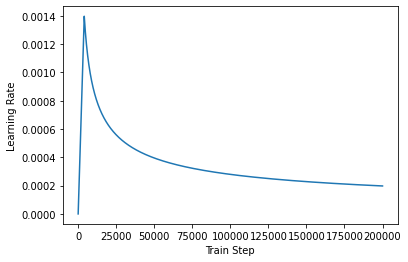

In [43]:
# 커스텀 학습률 스케줄링 계획 시각화 

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))   # tf.range(200000, dtype=tf.float32)는 학습 단계(step)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [44]:
# model compile

# CustomSchedule 클래스를 사용하여 학습률(learning rate)을 동적으로 조정합니다. 
# 이 학습률은 Adam 옵티마이저에 적용됩니다. D_MODEL은 모델 내부의 입출력 차원을 나타냅니다.
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저를 정의하고, 학습률을 지정합니다. beta_1, beta_2, epsilon 등은 Adam 옵티마이저의 하이퍼파라미터입니다.
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


## 훈련하기

In [45]:
# model fit

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 56s 217ms/step - loss: 1.3517 - accuracy: 0.0228
Epoch 2/20
185/185 [==============================] - 40s 215ms/step - loss: 1.0716 - accuracy: 0.0496
Epoch 3/20
185/185 [==============================] - 40s 215ms/step - loss: 0.9818 - accuracy: 0.0508
Epoch 4/20
185/185 [==============================] - 40s 216ms/step - loss: 0.9382 - accuracy: 0.0528
Epoch 5/20
185/185 [==============================] - 40s 215ms/step - loss: 0.9025 - accuracy: 0.0551
Epoch 6/20
185/185 [==============================] - 40s 215ms/step - loss: 0.8664 - accuracy: 0.0568
Epoch 7/20
185/185 [==============================] - 40s 216ms/step - loss: 0.8293 - accuracy: 0.0592
Epoch 8/20
185/185 [==============================] - 40s 215ms/step - loss: 0.7847 - accuracy: 0.0618
Epoch 9/20
185/185 [==============================] - 40s 215ms/step - loss: 0.7346 - accuracy: 0.0652
Epoch 10/20
185/185 [==============================] - 40s 215ms/step - l

# Step 5. 모델 평가하기
아래의 예측 단계로 챗봇을 테스트해보겠습니다.  

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [46]:
# 예측 단계 : decoder_inference() 함수 구현

def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]   # 마지막 시점의 정보만 선택

    # 현재 예측한 단어의 정수
    # 주어진 텐서 predictions에서 마지막 차원(가장 안쪽의 차원 / axis=1 / 어휘 크기)을 따라 최댓값을 가지는 요소의 인덱스를 반환
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료 (END_TOKEN[0]은 종료 토큰의 정수 인덱스)
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    # output_sequence 텐서에서 크기가 1인 차원을 제거 (디코더의 인퍼런스 프로세스 중에 생성된 시퀀스를 반환할 때 사용됨)
  return tf.squeeze(output_sequence, axis=0)

# 기본적으로 디코더의 인퍼런스는 현재까지의 예측된 시퀀스를 계속해서 누적하면서 진행됩니다. 
# 그러나 모델의 출력이 배치 차원을 가지고 있기 때문에, 이를 제거하고 최종 시퀀스를 반환하기 위해 tf.squeeze를 사용합니다. 
# 반환된 시퀀스는 실제 단어의 인덱스를 포함하며, 이는 모델이 생성한 문장입니다.

print("슝=3")

슝=3


임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [47]:
# 챗봇의 대답을 얻는 함수 구현 : decoder_inference() 함수를 호출하여

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### 임의의 문장으로부터 챗봇의 대답을 얻어보기

In [49]:
sentence_generation('여행가고 싶다!!')

입력 : 여행가고 싶다!!
출력 : 시원한 쥬스는 어때요 .


'시원한 쥬스는 어때요 .'

## 초기 실험
#### 하이퍼파라미터   
- num_layers=6
- d-Model=512
- EPOCHS=20

#### 결과
loss: 0.2685 - accuracy: 0.1204 이며,  
임의의 문장을 입력했을 때 나오는 답변도 맥락에 맞지 않습니다.  

Epochs을 높이고, 배치 사이즈를 64에서 32로 조정하여 다시 학습해보겠습니다.  
## 실험1 : BATCH_SIZE 64에서 32로 조정, EPOCHS 20에서 30으로 조정

In [51]:
BATCH_SIZE = 32

In [52]:
# model compile

# CustomSchedule 클래스를 사용하여 학습률(learning rate)을 동적으로 조정합니다. 
# 이 학습률은 Adam 옵티마이저에 적용됩니다. D_MODEL은 모델 내부의 입출력 차원을 나타냅니다.
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저를 정의하고, 학습률을 지정합니다. beta_1, beta_2, epsilon 등은 Adam 옵티마이저의 하이퍼파라미터입니다.
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [54]:
# model fit _에폭 20에서 30으로 조정

EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 40s 216ms/step - loss: 0.1895 - accuracy: 0.1349
Epoch 2/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1637 - accuracy: 0.1403
Epoch 3/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1485 - accuracy: 0.1436
Epoch 4/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1398 - accuracy: 0.1451
Epoch 5/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1338 - accuracy: 0.1459
Epoch 6/30
185/185 [==============================] - 40s 216ms/step - loss: 0.1290 - accuracy: 0.1465
Epoch 7/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1257 - accuracy: 0.1466
Epoch 8/30
185/185 [==============================] - 40s 216ms/step - loss: 0.1233 - accuracy: 0.1468
Epoch 9/30
185/185 [==============================] - 40s 215ms/step - loss: 0.1207 - accuracy: 0.1467
Epoch 10/30
185/185 [==============================] - 40s 215ms/step - l

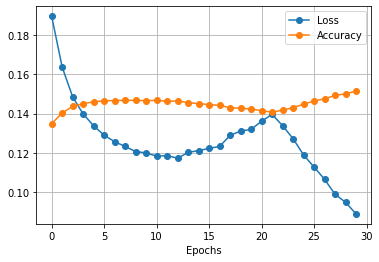

In [59]:
# 그래프로 시각화

plt.plot(history.history['loss'], label='Loss', marker='o')
plt.plot(history.history['accuracy'], label='Accuracy', marker='o')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

초기 학습에서 이어서 학습이 진행된 것으로 보입니다.  
accuracy는 소폭 상승하고 있으며, loss는 0.0890 수준으로 떨어졌습니다.

In [56]:
# 임의의 문장으로 테스트 해보기
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 상관없어요 .


'상관없어요 .'

In [57]:
# 임의의 문장으로 테스트 해보기
sentence_generation('고민이 있어')

입력 : 고민이 있어
출력 : 연락을 하셨군요 .


'연락을 하셨군요 .'

In [58]:
# 임의의 문장으로 테스트 해보기
sentence_generation('AI 공부가 쉽지가 않네.')

입력 : AI 공부가 쉽지가 않네.
출력 : 항상 함께였을테니까요 .


'항상 함께였을테니까요 .'

답변에 대한 의도는 느껴지지만 맥락에 아주 잘 맞는 답변이라고 느껴지지는 않습니다.  
3번째 문장의 경우 영어에 대해서는 전처리하지 않았던 것을 깨달아 이후 버전 파일에서는 영어 전처리를 하고 진행하겠습니다.  
에폭을 늘렸을 때 조금은 향상된 것으로 보여 이후 실험에서는 더 많은 에폭으로 실험해보겠습니다.

## 실험2 : BATCH_SIZE=64, EPOCHS 30에서 200으로 조정

In [63]:
BATCH_SIZE = 64

In [64]:
# model compile

# CustomSchedule 클래스를 사용하여 학습률(learning rate)을 동적으로 조정합니다. 
# 이 학습률은 Adam 옵티마이저에 적용됩니다. D_MODEL은 모델 내부의 입출력 차원을 나타냅니다.
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저를 정의하고, 학습률을 지정합니다. beta_1, beta_2, epsilon 등은 Adam 옵티마이저의 하이퍼파라미터입니다.
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [65]:
# model fit _에폭 30에서 200으로 조정

EPOCHS = 200
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 56s 216ms/step - loss: 0.0509 - accuracy: 0.1612
Epoch 2/200
185/185 [==============================] - 40s 214ms/step - loss: 0.0387 - accuracy: 0.1645
Epoch 3/200
185/185 [==============================] - 40s 215ms/step - loss: 0.0300 - accuracy: 0.1673
Epoch 4/200
185/185 [==============================] - 40s 215ms/step - loss: 0.0259 - accuracy: 0.1685
Epoch 5/200
185/185 [==============================] - 40s 214ms/step - loss: 0.0248 - accuracy: 0.1688
Epoch 6/200
185/185 [==============================] - 40s 215ms/step - loss: 0.0245 - accuracy: 0.1688
Epoch 7/200
185/185 [==============================] - 40s 215ms/step - loss: 0.0257 - accuracy: 0.1683
Epoch 8/200
185/185 [==============================] - 40s 215ms/step - loss: 0.0266 - accuracy: 0.1680
Epoch 9/200
185/185 [==============================] - 40s 214ms/step - loss: 0.0287 - accuracy: 0.1673
Epoch 10/200
185/185 [==============================] - 40s 215m

In [66]:
# 임의의 문장으로 테스트 해보기
sentence_generation('고민이 있어')

입력 : 고민이 있어
출력 : 연락을 하셨군요 .


'연락을 하셨군요 .'

In [69]:
# 맥락에 맞지 않는 답변이므로 데이터셋에 비슷한 answer가 있는지 확인해보기
data[data['A'] == '연락을 하셨군요.']

,Q,A,label
6163,또 일주일도 못가서ㅎㅎ,연락을 하셨군요.,1


연관성을 찾기 어려워보입니다.  
데이터셋에 있는 질문으로 테스트 해보겠습니다.

In [67]:
# 데이터셋의 문장으로 테스트 해보기
sentence_generation('결정은 빠르면 빠를 수록 좋겠지?')

입력 : 결정은 빠르면 빠를 수록 좋겠지?
출력 : 자신을 위한 결정을 내리길 바라요 .


'자신을 위한 결정을 내리길 바라요 .'

In [70]:
# 데이터셋의 문장으로 테스트 해보기 - 2
sentence_generation('내일이 기대돼')

입력 : 내일이 기대돼
출력 : 좋은 결과길 바라요 .


'좋은 결과길 바라요 .'

In [71]:
# 데이터셋의 실제 정답 확인
data[data['Q'] == '내일이 기대돼']

,Q,A,label
909,내일이 기대돼,좋은 일이 생길 거예요.,0


맥락에 맞는 다른 답변이 출력되었습니다. 데이터셋 내의 다른 질문도 테스트해보겠습니다.

In [72]:
# 데이터셋의 문장으로 테스트 해보기 - 3
sentence_generation(data['Q'][125])

입력 : 게임 같이 하자고 할까?
출력 : 안 될 것도 없죠 .


'안 될 것도 없죠 .'

In [75]:
# 데이터셋의 실제 정답 확인
data['A'][125]

'안 될 것도 없죠.'

In [78]:
# 데이터셋의 문장으로 테스트 해보기 - 4
sentence_generation('타이밍이 진짜 기막혀')

입력 : 타이밍이 진짜 기막혀
출력 : 그럴 때가 있어요 .


'그럴 때가 있어요 .'

In [79]:
# 데이터셋의 실제 정답 확인
data[data['Q'] == '타이밍이 진짜 기막혀']

,Q,A,label
4795,타이밍이 진짜 기막혀,그럴 때가 있어요.,0


데이터셋의 질문에는 데이터셋의 답변들이 잘 나옵니다.  
또한 에폭을 크게 높인다고 해서 accuracy가 드라마틱하게 높아지지 않음을 확인하였습니다.  
따라서 다음 실험에서는 다른 하이퍼파라미터를 변경하며 성능을 향상시켜보고자 합니다.

### 다음 노트북 파일에서는
- 일반화 성능을 높이기 위해 드롭아웃 0.5로 설정하여 다시 학습을 진행
- 영어, 숫자 관련 전처리 추가  
하여 진행해보겠습니다.

---
## 회고
### KEEP
- 어려운 개념들을 찾아 주석을 달면서 천천히 뜯어보았다.
- 전체 흐름과 개념들을 이해하기 위해 다른 자료들을 보며 익혔다.

### PROBLEM
- 모델 구조가 복잡하고 개념들이 어려워서 전반적인 단계가 아직 익숙하지 않다.
- 사용되는 함수가 너무 많아서 그 함수가 어디에서 사용되는지 정리가 안된다.
- 벡터 개념을 나올 때마다 대략적으로 이해하고 넘어가서 벡터 개념이 나올 때마다 계속 낯설다

### TRY
- 전체 단계와 각 단계에서의 핵심 개념을 정리하며 흐름을 익힌다. [복습 시 참고 자료](https://wikidocs.net/89786)
- 각 함수의 기능을 다시 익히고, 함수의 구체적인 작동 방법과 코드를 익히며 프로그래밍 부분도 복습한다.
- 벡터 관련한 간단한 개념과 예제들을 풀어본다.

## Reference
- [트랜스포머 모델, 작동 방식](https://www.youtube.com/watch?v=6s69XY025MU)
- [한국어 띄어쓰기, 맞춤법 검사 패키지](https://uding.tistory.com/11)